In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# from tensorflow.keras import layers
# from tensorflow.keras.utils import plot_model
# from tensorflow.keras import layers
# from tensorflow.keras.metrics import Precision, Recall
# from keras_flops import get_flops

# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D, BatchNormalization, Activation, Conv2DTranspose
# from tensorflow.keras.models import load_model, Model
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import gc
import os
from tqdm import tqdm
import keras.backend as K


In [12]:

def jaccard_loss(y_true, y_pred, smooth=1e-7):
    y_true = K.cast(y_true, dtype='float32')  # Cast y_true to float32
    intersection = K.sum(y_true * y_pred, axis=(1, 2, 3))
    union = K.sum(y_true, axis=(1, 2, 3)) + K.sum(y_pred, axis=(1, 2, 3)) - intersection
    jaccard = (intersection + smooth) / (union + smooth)
    return 1 - jaccard


def get_data(image_path="data/Lungs", mask_path="data/Infection", IMG_SIZE=128, i=None, j=None, normalize=False):
    img_names = os.listdir(image_path)    
    msk_names = os.listdir(mask_path)

    i = [0 if i is None else i][0]
    j = [len(img_names) if j is None else j][0]

    images, masks = np.zeros([j-i, IMG_SIZE, IMG_SIZE, 1]), np.zeros([j-i, IMG_SIZE, IMG_SIZE, 1])
    for index, (img, msk) in tqdm(enumerate(zip(img_names[i:j], msk_names[i:j]))):
        image = np.asarray(Image.open(f"{image_path}/{img}"))
        mask = np.asarray(Image.open(f"{mask_path}/{msk}"))

        # if normalize:
            # images[index] = MinMaxScaler().fit_transform(image)[..., np.newaxis]
        masks[index] = MinMaxScaler().fit_transform(mask)[..., np.newaxis]
        # else:
        images[index] = image[..., np.newaxis]
            # masks[index] = mask[..., np.newaxis]

    images, masks = np.array(images), np.array(masks)
    return images, masks

def IOU(y_true, y_pred, smooth=1e-6):
    y_true_flat = tf.cast(tf.reshape(y_true, [-1]), dtype=tf.float32)
    y_pred_flat = tf.cast(tf.reshape(y_pred, [-1]), dtype=tf.float32)

    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    print(f"IOU: {iou:.4f}")
    return iou


def save(path, images):
    for index, image in enumerate(images):
        image = np.squeeze(image)
        image = (image * 255).clip(0, 255).astype(np.uint8)
        Image.fromarray(image).save(f"{path}/{index}.png")

In [13]:
path = "models/UNet.h5"
lungs, masks = get_data(i=141, j=145)

model = tf.keras.models.load_model(path, custom_objects={"jaccard_loss": jaccard_loss})
pred = model.predict(lungs)

# print(lungs.shape, pred.shape, masks.shape)

IOU(masks.flatten(), pred.flatten())
save("outputs/", pred)


4it [00:00, 735.55it/s]


IOU: 0.6371


In [14]:
os.makedirs("outputs/", exist_ok=True)

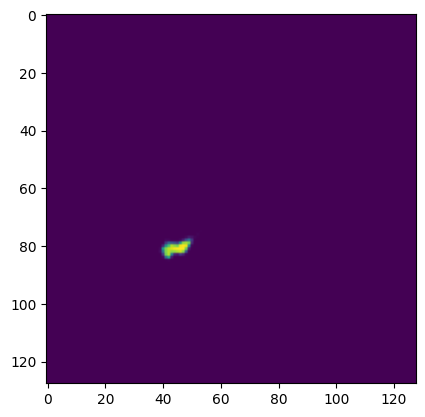

In [17]:
plt.imshow(pred[2])

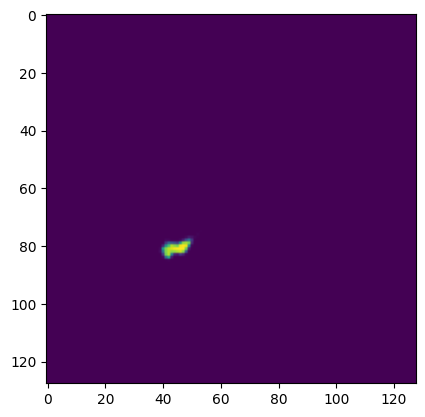

In [18]:
plt.imshow(pred[2])

In [ ]:
import keras.backend as K
def jaccard_loss(y_true, y_pred, smooth=1e-7):
    y_true = K.cast(y_true, dtype='float32')  # Cast y_true to float32
    intersection = K.sum(y_true * y_pred, axis=(1, 2, 3))
    union = K.sum(y_true, axis=(1, 2, 3)) + K.sum(y_pred, axis=(1, 2, 3)) - intersection
    jaccard = (intersection + smooth) / (union + smooth)
    return 1 - jaccard